# Select isobaths to use for ASC and heat transport calculation

Map of barotropic velocity (annual mean) and isobaths to select appropriate depth levels.

In [4]:
# Standard modules
from pathlib import Path
import cosima_cookbook as cc
from dask.distributed import Client
import numpy as np
import xarray as xr

import xgcm
import cf_xarray

# Load metpy module to obtain cross section 
# (Select the conda/analysis3-unstable kernel if you have problems loading this module)
# from metpy.interpolate import cross_section

# For plotting
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cmocean as cm
import pyproj

In [5]:
client = Client() # n_workers=4
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/39181/status,
Dashboard: /proxy/39181/status,Workers: 7
Total threads: 28,Total memory: 125.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:32903,Workers: 7
Dashboard: /proxy/39181/status,Total threads: 28
Started: Just now,Total memory: 125.20 GiB
Comm: tcp://127.0.0.1:32921,Total threads: 4
Dashboard: /proxy/36767/status,Memory: 17.89 GiB
Nanny: tcp://127.0.0.1:34787,


In [6]:
session = cc.database.create_session()
experiment = '01deg_jra55v13_ryf9091'

In [7]:
lat_slice  = slice(-80, -59)

start_time = '2086-01-01'
end_time   = '2086-12-31'

Bathymetry

In [18]:
hu = cc.querying.getvar(experiment, 'hu', session, n=1).sel(yu_ocean=lat_slice).load()  # .drop(['geolat_c', 'geolon_c'])

In [11]:
u = cc.querying.getvar(experiment, 'u', session, ncfile="ocean.nc",
                       start_time=start_time, end_time=end_time).sel(yu_ocean=lat_slice).mean('time')

v = cc.querying.getvar(experiment, 'v', session, ncfile="ocean.nc",
                       start_time=start_time, end_time=end_time).sel(yu_ocean=lat_slice).mean('time')


Vertical average

In [19]:
# Import edges of st_ocean and add lat/lon dimensions:
st_edges_ocean = cc.querying.getvar(experiment, 'st_edges_ocean', session, start_time=start_time, end_time=end_time, n=1)
st_edges_array = st_edges_ocean.expand_dims({'yu_ocean': u.yu_ocean, 'xu_ocean': u.xu_ocean}, axis=[1, 2])

In [23]:
# Adjust edges at bottom for partial thickness:
st_edges_with_partial = st_edges_array.where(st_edges_array<hu, other=hu)
thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

# Change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = cc.querying.getvar(experiment, 'st_ocean', session, n=1)
thickness['st_edges_ocean'] = st_ocean.values
thickness = thickness.rename(({'st_edges_ocean': 'st_ocean'}))
thickness = thickness.sel(st_ocean=slice(0, 500))

# Depth average gives us the barotropic velocity
u_bt = (u * thickness).sum('st_ocean') / thickness.sum('st_ocean')
v_bt = (v * thickness).sum('st_ocean') / thickness.sum('st_ocean')

In [27]:
# Speed
speed = np.sqrt(u_bt**2 + v_bt**2).load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/dask/core.py:129: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/dask/core.py:129: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/dask/core.py:129: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/dask/core.py:129: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/dask/core.py:129: RuntimeWarning: invalid value encountered in divide
 

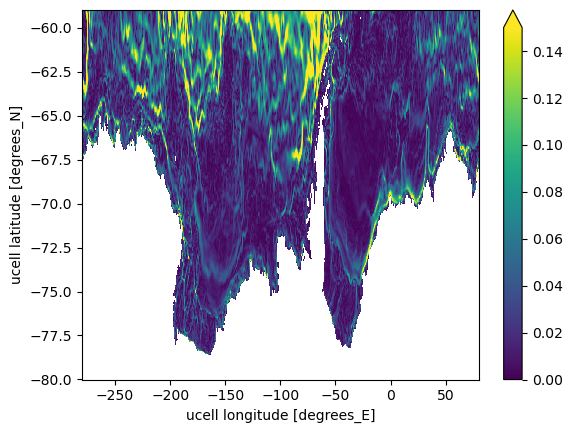

In [29]:
speed.plot(vmin=0, vmax=0.15)

Plotting

In [30]:
theta  = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.45
verts  = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [31]:
land = xr.where(np.isnan(hu.rename('land')), 1, np.nan)

In [32]:
ft_size = 16
plt.rcParams.update({'font.size': ft_size})

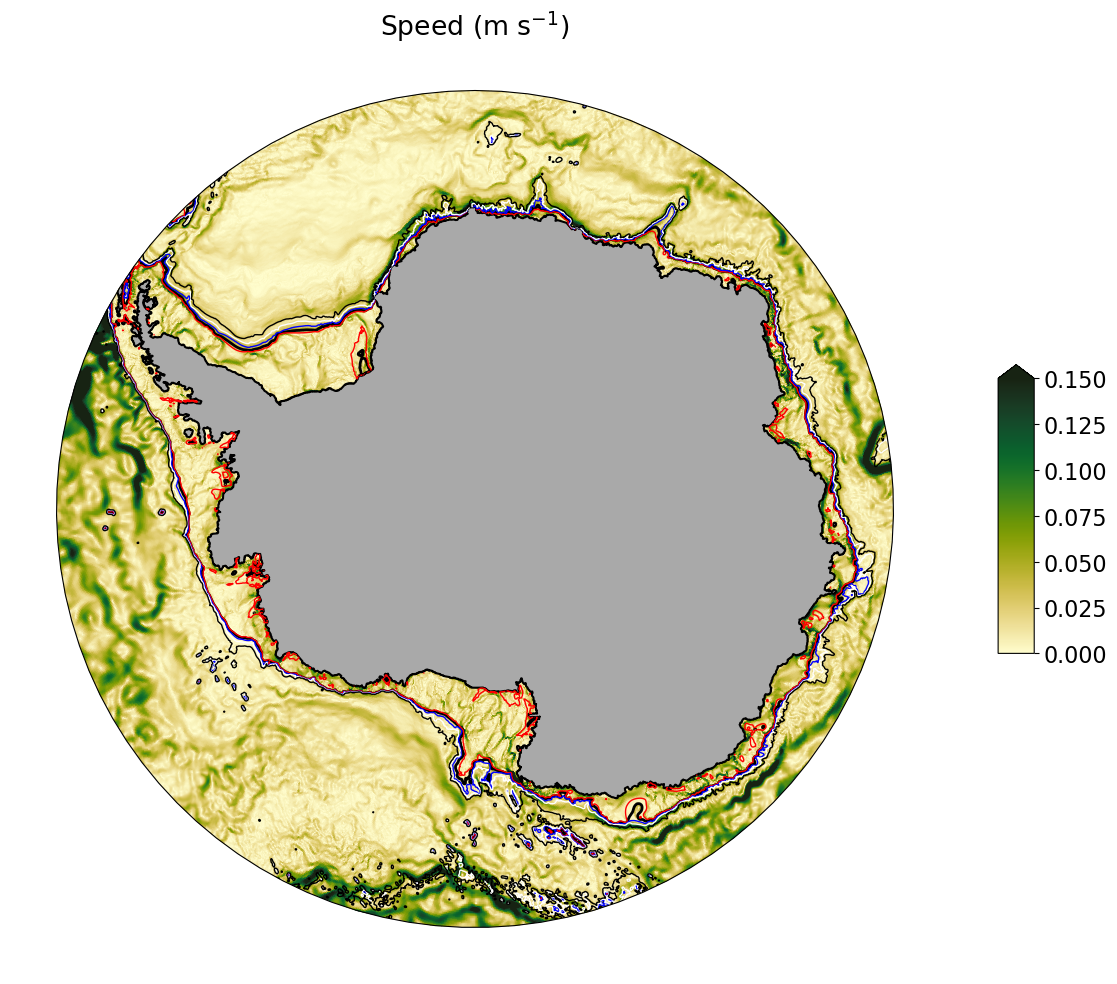

In [73]:
fig = plt.figure(1, figsize=(15, 15))

ax = plt.subplot(1, 1, 1, projection=ccrs.SouthPolarStereo(), facecolor="darkgrey")
ax.set_boundary(circle, transform=ax.transAxes)
    
# Filled land 
land.plot.contourf(ax=ax, colors='darkgrey', zorder=2,
                   transform=ccrs.PlateCarree(), add_colorbar=False)

# Coastline
land.fillna(0).plot.contour(ax=ax, colors='k', levels=[0, 1],
                            transform=ccrs.PlateCarree(), add_colorbar=False)

# Depth contours
hu.plot.contour(ax=ax, levels=[1000], colors='k', linewidths=2, transform=ccrs.PlateCarree())
hu.plot.contour(ax=ax, levels=[700], colors='r', linewidths=1, transform=ccrs.PlateCarree())
hu.plot.contour(ax=ax, levels=[1500], colors='b', linewidths=1, transform=ccrs.PlateCarree())
hu.plot.contour(ax=ax, levels=[2000], colors='w', linewidths=1, transform=ccrs.PlateCarree())
hu.plot.contour(ax=ax, levels=[2500], colors='k', linewidths=1, transform=ccrs.PlateCarree())

# Along slope barotropic velocity
sc = speed.plot(ax=ax, cmap=cm.cm.speed,
                       transform=ccrs.PlateCarree(), vmin=0, vmax=0.15,
                       cbar_kwargs={'orientation': 'vertical',
                                    'shrink': 0.25,
                                    'extend': 'max',
                                    'label': None,
                                    'aspect': 8})

ax.set_title('Speed (m s$^{-1}$)');

plt.savefig('/g/data/x77/wgh581/Figures/Figures_ASC_and_HeatTransport/Fig_speed_bathymetry_contours.png')

Sectors

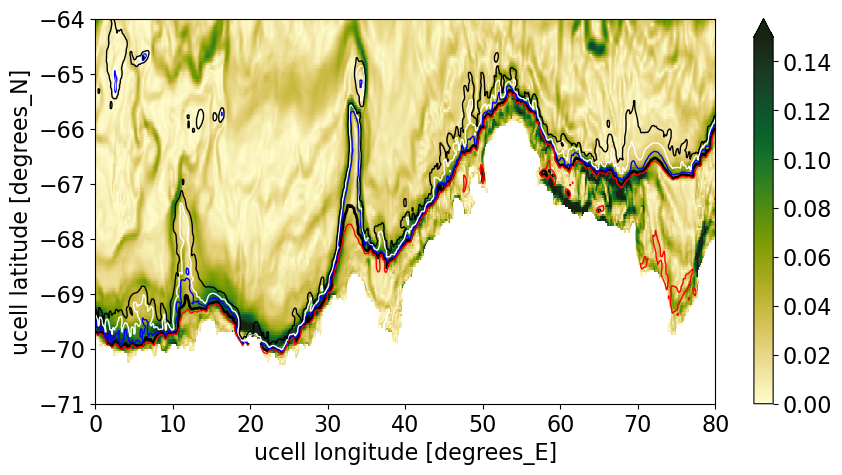

In [69]:
fig = plt.figure(figsize=(10,5))
speed.plot(cmap=cm.cm.speed, vmin=0, vmax=0.15)

# Depth contours
hu.plot.contour(levels=[1000], colors='k', linewidths=2)
hu.plot.contour(levels=[700], colors='r', linewidths=1)
hu.plot.contour(levels=[1500], colors='b', linewidths=1)
hu.plot.contour(levels=[2000], colors='w', linewidths=1)
hu.plot.contour(levels=[2500], colors='k', linewidths=1)

plt.xlim(0, 80)
plt.ylim(-71, -64);

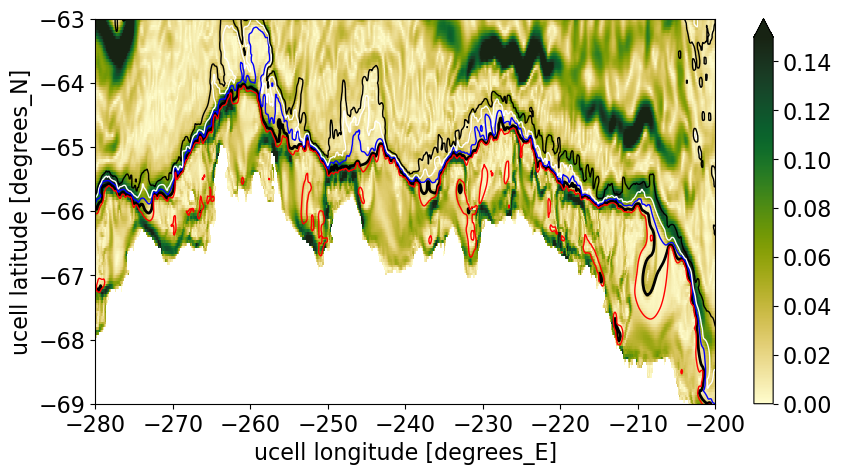

In [68]:
fig = plt.figure(figsize=(10,5))
speed.plot(cmap=cm.cm.speed, vmin=0, vmax=0.15)

# Depth contours
hu.plot.contour(levels=[1000], colors='k', linewidths=2)
hu.plot.contour(levels=[700], colors='r', linewidths=1)
hu.plot.contour(levels=[1500], colors='b', linewidths=1)
hu.plot.contour(levels=[2000], colors='w', linewidths=1)
hu.plot.contour(levels=[2500], colors='k', linewidths=1)

plt.xlim(-280,-200)
plt.ylim(-69, -63);

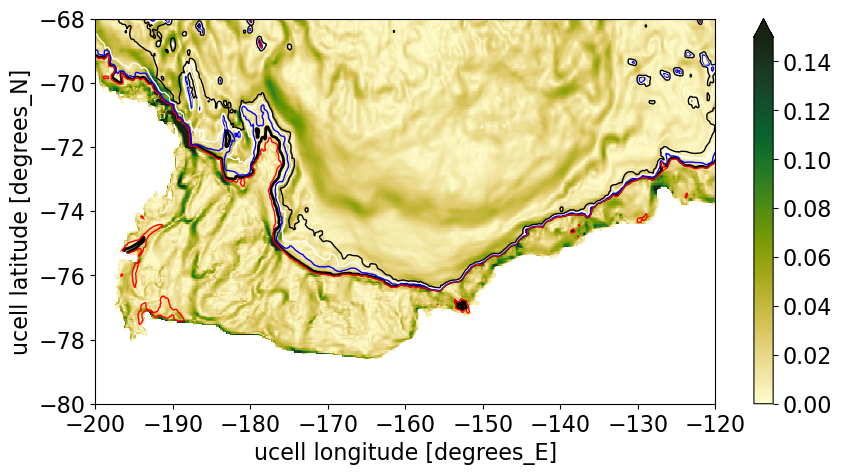

In [62]:
fig = plt.figure(figsize=(10,5))
speed.plot(cmap=cm.cm.speed, vmin=0, vmax=0.15)

# Depth contours
hu.plot.contour(levels=[1000], colors='k', linewidths=2)
hu.plot.contour(levels=[800], colors='r', linewidths=1)
hu.plot.contour(levels=[1500], colors='b', linewidths=1)
hu.plot.contour(levels=[2000], colors='w', linewidths=1)
hu.plot.contour(levels=[2500], colors='k', linewidths=1)

plt.xlim(-200,-120)
plt.ylim(-80, -68);

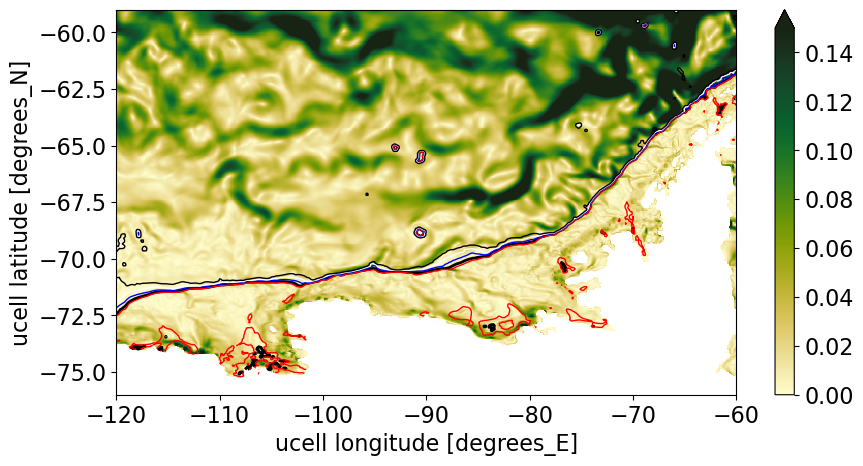

In [71]:
fig = plt.figure(figsize=(10,5))
speed.plot(cmap=cm.cm.speed, vmin=0, vmax=0.15)

# Depth contours
hu.plot.contour(levels=[1000], colors='k', linewidths=2)
hu.plot.contour(levels=[700], colors='r', linewidths=1)
hu.plot.contour(levels=[1500], colors='b', linewidths=1)
hu.plot.contour(levels=[2000], colors='w', linewidths=1)
hu.plot.contour(levels=[2500], colors='k', linewidths=1)

plt.xlim(-120,-60)
plt.ylim(-76, -59);

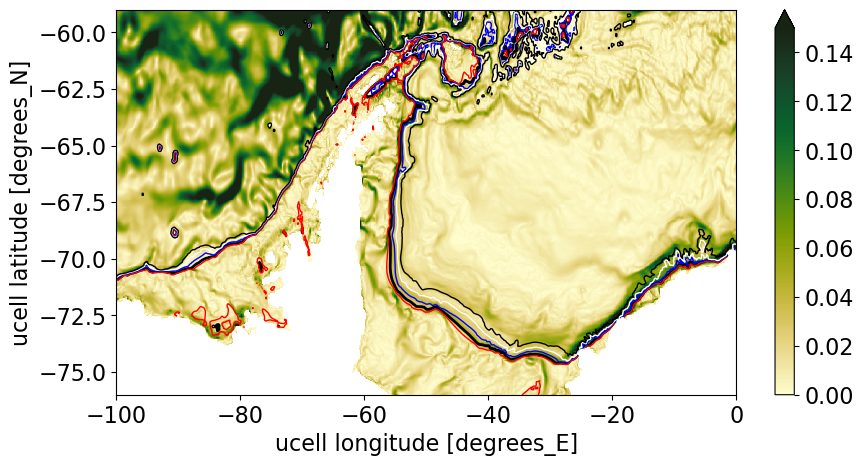

In [72]:
fig = plt.figure(figsize=(10,5))
speed.plot(cmap=cm.cm.speed, vmin=0, vmax=0.15)

# Depth contours
hu.plot.contour(levels=[1000], colors='k', linewidths=2)
hu.plot.contour(levels=[700], colors='r', linewidths=1)
hu.plot.contour(levels=[1500], colors='b', linewidths=1)
hu.plot.contour(levels=[2000], colors='w', linewidths=1)
hu.plot.contour(levels=[2500], colors='k', linewidths=1)

plt.xlim(-100,0)
plt.ylim(-76, -59);